## Load and Visualize data

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm

In [2]:
!ls /content/drive/MyDrive/spiders/train/

'Black Widow'		'Deinopis Spider'	 'Peacock Spider'
'Blue Tarantula'	'Golden Orb Weaver'	 'Red Knee Tarantula'
'Bold Jumper'		'Hobo Spider'		 'Spiny-backed Orb-weaver'
'Brown Grass Spider'	'Huntsman Spider'	 'White Kneed Tarantula'
'Brown Recluse Spider'	'Ladybird Mimic Spider'  'Yellow Garden Spider'


In [3]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/spiders/test")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['Black Widow' 'Blue Tarantula' 'Bold Jumper' 'Brown Grass Spider'
 'Brown Recluse Spider' 'Deinopis Spider' 'Golden Orb Weaver'
 'Hobo Spider' 'Huntsman Spider' 'Ladybird Mimic Spider' 'Peacock Spider'
 'Red Knee Tarantula' 'Spiny-backed Orb-weaver' 'White Kneed Tarantula'
 'Yellow Garden Spider']


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup the target directory (Where we will view images)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  
  # read in the image and plot using matplot lib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['088.jpg']
Image shape: (224, 224, 3)


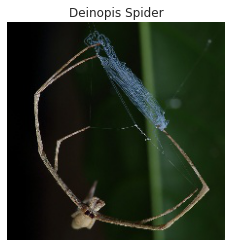

In [5]:
img = view_random_image(target_dir="/content/drive/MyDrive/spiders/train/",
                        target_class=class_names[random.randint(0,14)])

### Create dataframes

In [6]:
def make_dataframes(train_dir, test_dir, valid_dir): 
    """
    Create 3 dataframes, a class list, and class count using three Directory paths. 

    Iterates through directories in dataset format to create pandas Dataframes.
    """
    # create zip() iterable for while loop and naming conventions
    dirlist=[train_dir, test_dir, valid_dir]
    names=['train', 'test', 'valid']
    ziplist=zip(names, dirlist)

    ## unpack ziplist for naming resepective directory
    for name, directory in ziplist:        
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(directory) )    

        ## iterate through every class in the current directory
        ## and start another for loop to go through each class folder
        for klass in classlist:
            classpath=os.path.join(directory, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{klass:25s}'

            ## tqdm to create nice visual representation of image loading
            ## 
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='green'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
            
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name == 'train':
            train_df=df
        elif name == 'test':
            test_df=df        
        else:
            valid_df=df 
            
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

In [7]:
train_dir = "/content/drive/MyDrive/spiders/train"
valid_dir = "/content/drive/MyDrive/spiders/valid"
test_dir = "/content/drive/MyDrive/spiders/test"

In [8]:
train_df, test_df, valid_df, classes, class_count = make_dataframes(train_dir, test_dir, valid_dir)

valid -Yellow Garden Spider     : 100%|███████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34379.54files/s]


number of classes in processed dataset=  15
the maximum files in any class in train_df is  189   the minimum files in any class in train_df is  104
train_df length:  2185   test_df length:  75   valid_df length:  75
average image height=  224   average image width=  224  aspect ratio h/w=  1.0


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=200 # number of samples in each class
working_dir=r'/content/drive/MyDrive/TensorFlow/Datasets/Spider_augment' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)  

Initial length of dataframe is  2185
Found 122 validated image filenames.
Found 160 validated image filenames.
Found 189 validated image filenames.
Found 136 validated image filenames.
Found 140 validated image filenames.
Found 120 validated image filenames.
Found 153 validated image filenames.
Found 152 validated image filenames.
Found 168 validated image filenames.
Found 104 validated image filenames.
Found 157 validated image filenames.
Found 127 validated image filenames.
Found 154 validated image filenames.
Found 126 validated image filenames.
Found 177 validated image filenames.
Total Augmented images created=  815
Length of augmented dataframe is now  3000


In [10]:


def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)



Found 3000 validated image filenames belonging to 15 classes.
Found 75 validated image filenames belonging to 15 classes.
Found 75 validated image filenames belonging to 15 classes.
test batch size:  75   test steps:  1  number of classes :  15


In [11]:


def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )



In [ ]:

def make_model(img_size, lr, net_num=3, dropout=0.4):  
    """
    Creates a Keras efficient net of choice depending on Number input. options are 0, 3, and 5.
    Defaults to 3

    Modifies Net to be trainable and adds additional layers.
     - Creats Batch normalization layer
     - A 256 neuron dense layer with l2 and l1 regulization
     - Adds a Dropout layer with input paramater value
     - Finally creates the Dense output layer.
    """
    img_shape=(img_size[0], img_size[1], 3)


    if net_num == 0:
      base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    elif net_num == 3:
      base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    else:
      base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
      net_num = 5

    print("Created an EfficientNetB{}".format(net_num))

    base_model.trainable=True

    x = base_model.output
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer=tf.keras.regularizers.l1(0.006),
                    bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=dropout, seed=42)(x)       
    output = tf.keras.layers.Dense(class_count, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    model.compile(tf.keras.optimizers.Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

    
    return model

spider_model_pretrained = make_model(img_size, lr=.001, net_num=0)

16705208/16705208 [==============================] - 0s 0us/step
Created an EfficientNetB0


### Define Callbacks

In [ ]:
def print_in_color(txt_msg,fore_tuple=(0,255,255),back_tuple=(100,100,100)):
    """
      prints the text_msg in the foreground color specified by fore_tuple with the background specified by back_tuple 
      text_msg is the text, fore_tuple is foregroud color tuple (r,g,b), back_tuple is background tuple (r,g,b)
      default parameter print in cyan foreground and gray background
    """
    rf,gf,bf=fore_tuple
    rb,gb,bb=back_tuple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [ ]:
class LR_ASK(tf.keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # 
        """
        define a function to return the list of % validation change
        """
        return self.plist, self.alist

    # runs at the beginning of training
    # Initializes data for ask var
    # Grabs start timer
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', self.epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg)
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground

            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)

                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground

                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

In [ ]:

epochs=40
ask_epoch=5
ask=LR_ASK(spider_model_pretrained, epochs,  ask_epoch)
callbacks=[ask]

In [ ]:

history=spider_model_pretrained.fit(x=train_gen,  epochs=epochs, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, callbacks=callbacks)



Training will proceed until epoch 5 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 7.9143 - accuracy: 0.6850
 validation loss of  6.5478 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

100/100 [==============================] - 469s 5s/step - loss: 7.9143 - accuracy: 0.6850 - val_loss: 6.5478 - val_accuracy: 0.8933
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 5.8175 - accuracy: 0.9073
 validation loss of  5.0319 is 23.1511 % below lowest loss, saving weights from epoch 2   as best weights

100/100 [==============================] - 458s 5s/step - loss: 5.8175 - accuracy: 0.9073 - val_loss: 5.0319 - val_accuracy: 0.9867
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 4.5442 - accuracy: 0.9493
 validation

In [ ]:
import tensorflow as tf

model_1 = tf.keras.models.load_model('/content/drive/MyDrive/TensorFlow/Models/Trained_models/spiders_97.33.h5')

model_1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
y_preds = model_1.predict(test_gen)
y_preds

NameError: ignored

## Visualize test images labeled with prediction and True label. 

## Visualize computer generated edges because it looks cool.

In [ ]:

t_dict=test_gen.class_indices
classes=list(t_dict.keys())    
images,labels=next(test_gen) 
y_true = [np.argmax(element) for element in labels]
length=len(labels)
plt.figure(figsize=(25, 25))


for i in range(16):        
        plt.subplot(4, 4, i + 1)
        if i%2 == 0:
          image=images[i] /255 
          index=np.argmax(labels[i])
        else:
          image = images[i-1]  
          index=np.argmax(labels[i - 1])  
   
        plt.imshow(image)
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

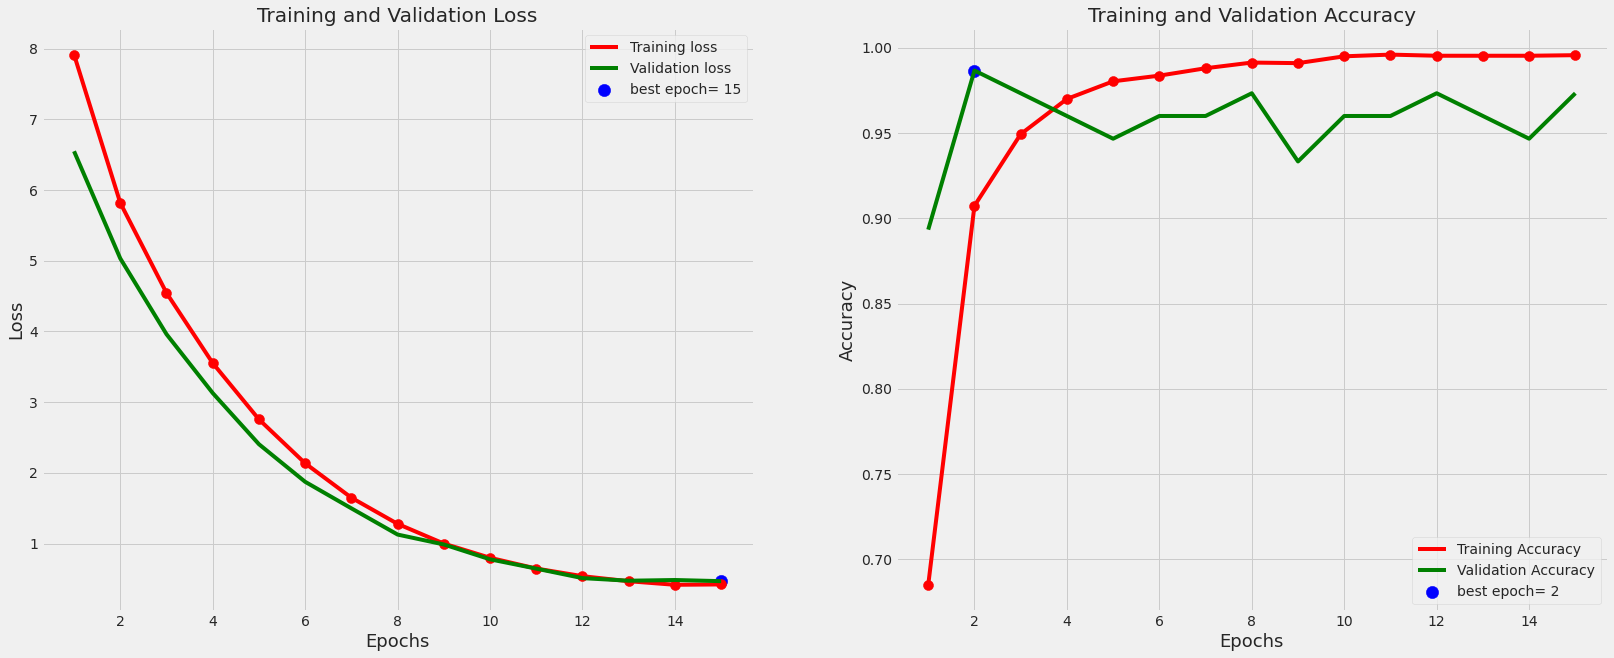

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

1/1 [==============================] - 5s 5s/step
there were 2 errors in 75 tests for an accuracy of  97.33



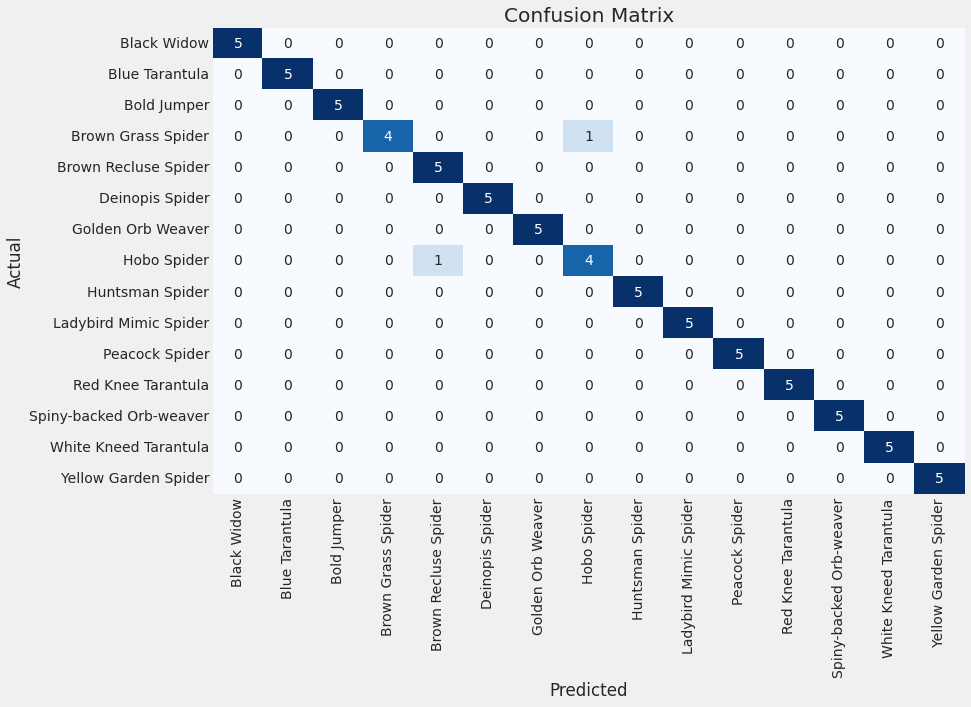

Classification Report:
----------------------
                          precision    recall  f1-score   support

            Black Widow     1.0000    1.0000    1.0000         5
         Blue Tarantula     1.0000    1.0000    1.0000         5
            Bold Jumper     1.0000    1.0000    1.0000         5
     Brown Grass Spider     1.0000    0.8000    0.8889         5
   Brown Recluse Spider     0.8333    1.0000    0.9091         5
        Deinopis Spider     1.0000    1.0000    1.0000         5
      Golden Orb Weaver     1.0000    1.0000    1.0000         5
            Hobo Spider     0.8000    0.8000    0.8000         5
        Huntsman Spider     1.0000    1.0000    1.0000         5
  Ladybird Mimic Spider     1.0000    1.0000    1.0000         5
         Peacock Spider     1.0000    1.0000    1.0000         5
     Red Knee Tarantula     1.0000    1.0000    1.0000         5
Spiny-backed Orb-weaver     1.0000    1.0000    1.0000         5
  White Kneed Tarantula     1.0000    1.00

In [ ]:
def predictor(test_gen, test_steps, model):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list

errors, tests, error_list, error_pred_list =predictor(test_gen, test_steps, model=spider_model_pretrained)

In [ ]:


if len(error_list) > 0:
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))
    for i in range(len(error_list)):
        fpath=error_list[i]
        split=fpath.split('/')
        f=split[4]+ '-' + split[5]
        print(f'{f:^30s}{error_pred_list[i]:^30s}')
        



Below is a list of test files that were miss classified 

          Test File                    Predicted as         
         spiders-test                  Hobo Spider          
         spiders-test              Brown Recluse Spider     


In [ ]:
working_dir=r'/content/drive/MyDrive/TensorFlow/Models/Trained_models'
subject='spiders' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
spider_model_pretrained.save(model_save_loc)
msg= f'model was saved as {model_save_loc}'
print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

model was saved as /content/drive/MyDrive/TensorFlow/Models/Trained_models/spiders_97.33.h5



# Latter half, constructing a CNN from Scratch (Postponed WIP)

## Data Pre-processing

* Load images as dataset using Keras utils
* Preprocess(normalize) the images
* Create Training and Validation set

In [ ]:
scaling_layer = tf.keras.layers.Rescaling(1./255)
dataset = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/spiders/train",
                                                      batch_size=16,
                                                      image_size=(224,224),
                                                      seed=42,
                                              )

Found 2185 files belonging to 15 classes.


In [ ]:
valid_data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/spiders/valid",
                                          batch_size=16,
                                          image_size=(224, 224),
                                          seed=42,
                                          )
valid_data_scaled = valid_data.map(lambda x, y: (scaling_layer(x), y))

Found 75 files belonging to 15 classes.


In [ ]:
train_data_scaled = dataset.map(lambda x, y: (scaling_layer(x), y))

<bound method _NumpyIterator.next of <tensorflow.python.data.ops.dataset_ops._NumpyIterator object at 0x7f0d579ea2d0>>

### Callbacks
#### ** Creating callbacks with seperate models in mind **

* First callbacks will be standard for model created from scratch ()

* Custom callbacks created for comparison between transfer learning and scratch model tuning



In [ ]:
## Create a Checkpoint Callback to save Best performing model. 

checkpoint_filepath = '/content/drive/MyDrive/TensorFlow/Models/Callback_Models/Spider callback'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
cb = [
             EarlyStopping(patience=3),
             model_checkpoint_callback,
      
]

## Creating the CNN model

* Standard image classification problem
* 15 classes 

### Model from scratch
* Batch normalization between each layer
* increase filter limit after each MaxPool

### Model using Transfer learning
* Use keras EfficientNet (Any will suffice, but we'll use b3)
* Use Custom Callback to adjust values at points in training



In [ ]:
spider_model = tf.keras.Sequential([
    
    
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPool2D(padding='valid'),

    tf.keras.layers.RandomFlip(),
    
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(padding='valid'),

    tf.keras.layers.Conv2D(12, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(14, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation='softmax')])

In [ ]:
spider_model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']) 

In [ ]:
history_1 = spider_model.fit(train_data_scaled, 
                        epochs=15,
                        steps_per_epoch=len(train_data_scaled),
                        validation_data=valid_data_scaled,
                        validation_steps=len(valid_data_scaled),
                        callbacks=cb,
                        )

Epoch 1/15
137/137 [==============================] - 190s 1s/step - loss: 3.1822 - accuracy: 0.2330 - val_loss: 3.4436 - val_accuracy: 0.1333
Epoch 2/15
137/137 [==============================] - 183s 1s/step - loss: 2.2500 - accuracy: 0.3730 - val_loss: 2.7428 - val_accuracy: 0.2133
Epoch 3/15
137/137 [==============================] - 183s 1s/step - loss: 1.9507 - accuracy: 0.4220 - val_loss: 1.6029 - val_accuracy: 0.4133
Epoch 4/15
137/137 [==============================] - 183s 1s/step - loss: 1.7331 - accuracy: 0.4645 - val_loss: 1.1458 - val_accuracy: 0.6000
Epoch 5/15
137/137 [==============================] - 185s 1s/step - loss: 1.6258 - accuracy: 0.4952 - val_loss: 1.2175 - val_accuracy: 0.6000
Epoch 6/15
137/137 [==============================] - 186s 1s/step - loss: 1.5007 - accuracy: 0.5213 - val_loss: 1.0568 - val_accuracy: 0.6267
Epoch 7/15
137/137 [==============================] - 184s 1s/step - loss: 1.4109 - accuracy: 0.5469 - val_loss: 1.1228 - val_accuracy: 0.5600

KeyboardInterrupt: ignored

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/spiders/test",
                                                        batch_size=16,
                                                        image_size=(224, 224),
                                                        seed=42,)
test_data_scaled = test_data.map(lambda x, y: (scaling_layer(x), y))

In [ ]:
spider_model.evaluate(test_data_scaled)